In [1]:
%pip install -q scikit-learn-intelex shap cloudpickle

# Patch scikit-learn for Intel optimizations
from sklearnex import patch_sklearn
patch_sklearn()

import sys
from pathlib import Path
import pandas as pd
import joblib
import cloudpickle
import matplotlib.pyplot as plt
import shap

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split

Note: you may need to restart the kernel to use updated packages.


Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# Setup Paths and Load Data

This section sets up the paths for the project root, processed data, and model directories. It ensures that the correct directory structure is found, and paths are appended to sys.path to allow easy import of required resources.

In [2]:
# Locate project root
project_root = Path().resolve()
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent
sys.path.append(str(project_root))

In [3]:
processed_dir = project_root / "data" / "processed"
model_dir = project_root / "models" / "trained_model"

Here, the feature columns and dataset (X and y) is loaded after ensuring proper formatting. The target y is cleaned and converted to integers, while the features X are labeled with the correct column names.

In [4]:
# Load feature columns
feature_columns = joblib.load(processed_dir / "feature_columns.pkl")

In [5]:
# Load data
X = pd.read_csv(processed_dir / "X_smote.csv", header=0)
X.columns = feature_columns
y = pd.read_csv(processed_dir / "y_smote.csv", header=0).squeeze("columns")
y = pd.to_numeric(y, errors="coerce").dropna().astype(int).reset_index(drop=True)

This step ensures that the feature matrix X and target vector y have matching lengths, trimming the data if necessary.

In [6]:
# Ensure matching lengths
min_len = min(len(X), len(y))
X, y = X.iloc[:min_len], y.iloc[:min_len]

The data is split into training and testing sets (80/20) with stratification to maintain the same distribution of labels in both sets.

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Load Models Safely 

We attempt to load the trained models from disk using both joblib and cloudpickle for compatibility. If one method fails, the code falls back to the other.

In [8]:
model_names = ["LogisticRegression", "RandomForest", "GradientBoosting", "XGBoost", "MLP"]
models = {}

In [9]:
for name in model_names:
    pkl_path = model_dir / f"{name.lower()}_model.pkl"
    try:
        models[name] = joblib.load(pkl_path)
    except AttributeError as e:
        print(f"[WARNING] Joblib failed for {name}: {e}")
        print(f"[INFO] Trying cloudpickle instead...")
        with open(pkl_path, "rb") as f:
            models[name] = cloudpickle.load(f)

c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.5.1 when using version 1.6.1. This might lead to b

# Evaluate Each Model

We loop through each model and check if it’s a valid classifier. For valid classifiers, we predict both the labels (y_pred) and probabilities (y_proba) for the test set. The classification report and ROC-AUC score are printed to evaluate the model's performance on the test data. We then generate and display the confusion matrix to visualize how the model is classifying the test data. The ROC curve is plotted to visualize the trade-off between the true positive rate (sensitivity) and the false positive rate for the model.

In [10]:
from sklearn.base import ClassifierMixin

In [23]:
def evaluate_model(name, model, X_test, y_test):
    if not isinstance(model, ClassifierMixin):
        print(f"[WARNING] Skipping {name} - Not a valid classifier model.")
        return

    try:
        print(f"\n=== {name} Evaluation ===")
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        print(classification_report(y_test, y_pred))
        print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"{name} - Confusion Matrix")
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title(f'{name} - ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid()
        plt.show()

    except Exception as e:
        print(f"[ERROR] Failed to evaluate {name}: {e}")


=== LogisticRegression Evaluation ===


c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.76      0.82      0.79    113976
           1       0.81      0.74      0.77    113975

    accuracy                           0.78    227951
   macro avg       0.79      0.78      0.78    227951
weighted avg       0.79      0.78      0.78    227951

ROC-AUC: 0.8647


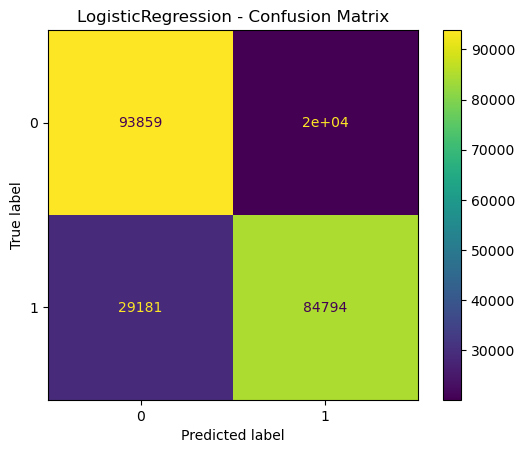

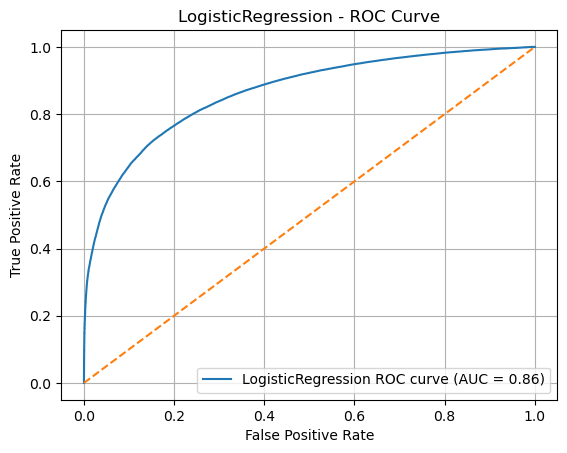

In [12]:
evaluate_model("LogisticRegression", models["LogisticRegression"], X_test, y_test)

# Visualization Evaluation of Logistic Regression

The model has a higher precision for class 1 (fraud) at 0.81, meaning it is good at identifying actual fraud cases without too many false positives. However, the recall for class 1 is 0.74, indicating that 26% of actual fraud cases are missed. This balance suggests the model is cautious in labeling transactions as fraud, which is important to avoid inconveniencing legitimate users. The F1-scores for both classes are close (0.79 for class 0 and 0.77 for class 1), indicating a balanced performance. This is crucial in fraud detection, where both false positives (legitimate transactions flagged as fraud) and false negatives (fraudulent transactions not detected) need to be minimized. The ROC-AUC score of 0.8647 shows that the model has a good ability to distinguish between fraudulent and legitimate transactions. This high score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent. The nearly equal support for both classes (around 113,976 for each) suggests that the dataset is balanced, which is beneficial for training a robust fraud detection model. The confusion matrix further supports these findings, with the model correctly identifying a large number of non-fraudulent transactions (93,859) and fraudulent transactions (84,794). However, there are 20,000 false positives, which could lead to inconvenience for legitimate users flagged as fraud, and 29,181 false negatives, highlighting an area for improvement to ensure more fraud cases are detected. Additionally, the ROC curve shows an AUC of 0.86, reinforcing the model's strong performance in distinguishing between fraudulent and legitimate transactions. This high AUC score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent.


=== RandomForest Evaluation ===


c:\Users\danar\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\danar\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\danar\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\danar\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    113976
           1       1.00      0.99      0.99    113975

    accuracy                           0.99    227951
   macro avg       0.99      0.99      0.99    227951
weighted avg       0.99      0.99      0.99    227951

ROC-AUC: 0.9993


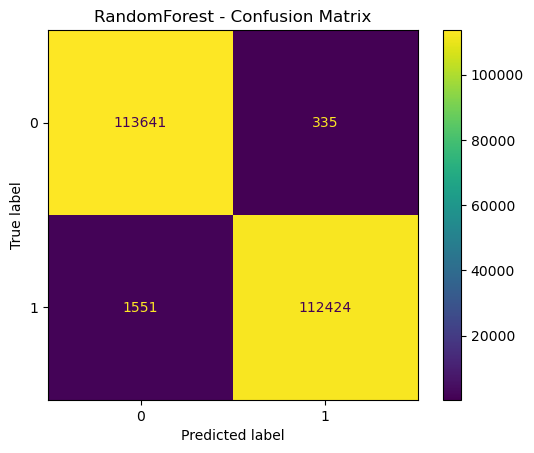

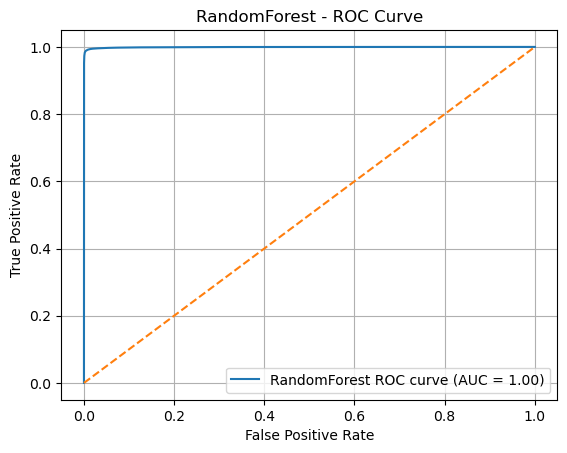

In [13]:
evaluate_model("RandomForest", models["RandomForest"], X_test, y_test)

# Visualization Evaluation of Random Forest Model

The model has a higher precision for class 1 (fraud) at 1.00, meaning it is excellent at identifying actual fraud cases without any false positives. However, the recall for class 1 is 0.99, indicating that 1% of actual fraud cases are missed. This balance suggests the model is cautious in labeling transactions as fraud, which is important to avoid inconveniencing legitimate users. The F1-scores for both classes are close (0.99 for both class 0 and class 1), indicating a balanced performance. This is crucial in fraud detection, where both false positives (legitimate transactions flagged as fraud) and false negatives (fraudulent transactions not detected) need to be minimized. The ROC-AUC score of 1.00 shows that the model has a perfect ability to distinguish between fraudulent and legitimate transactions. This high score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent. The nearly equal support for both classes (around 113,976 for each) suggests that the dataset is balanced, which is beneficial for training a robust fraud detection model. The confusion matrix further supports these findings, with the model correctly identifying a large number of non-fraudulent transactions (113,641) and fraudulent transactions (112,424). However, there are 335 false positives, which could lead to inconvenience for legitimate users flagged as fraud, and 1,551 false negatives, highlighting an area for improvement to ensure more fraud cases are detected. Additionally, the ROC curve shows an AUC of 1.00, reinforcing the model's strong performance in distinguishing between fraudulent and legitimate transactions. This high AUC score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent.


=== GradientBoosting Evaluation ===
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    113976
           1       0.95      0.90      0.93    113975

    accuracy                           0.93    227951
   macro avg       0.93      0.93      0.93    227951
weighted avg       0.93      0.93      0.93    227951

ROC-AUC: 0.9784


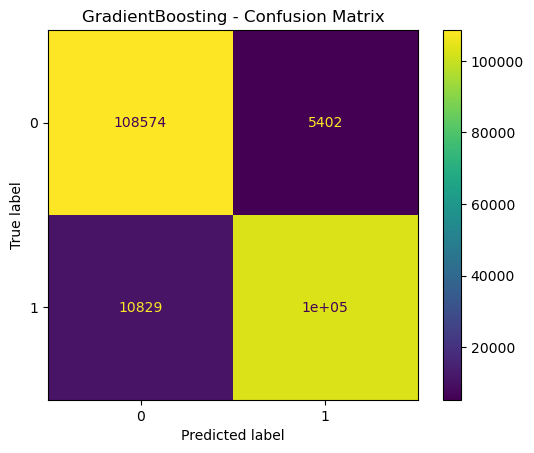

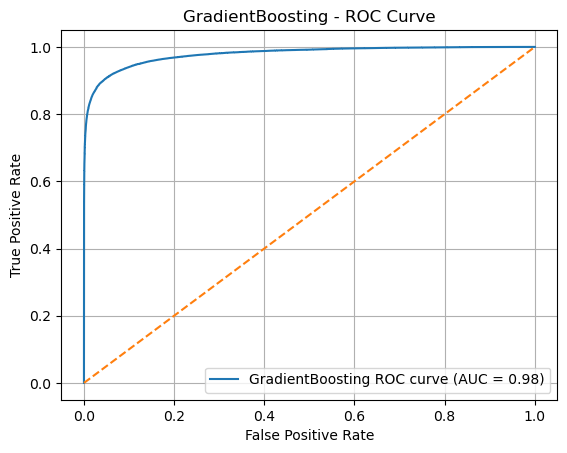

In [14]:
evaluate_model("GradientBoosting", models["GradientBoosting"], X_test, y_test)

# Visualization of Gradient Boosting Model

The model has a higher precision for class 1 (fraud) at 0.95, meaning it is good at identifying actual fraud cases without too many false positives. However, the recall for class 1 is 0.90, indicating that 10% of actual fraud cases are missed. This balance suggests the model is cautious in labeling transactions as fraud, which is important to avoid inconveniencing legitimate users. The F1-scores for both classes are close (0.93 for both class 0 and class 1), indicating a balanced performance. This is crucial in fraud detection, where both false positives (legitimate transactions flagged as fraud) and false negatives (fraudulent transactions not detected) need to be minimized. The ROC-AUC score of 0.9784 shows that the model has a strong ability to distinguish between fraudulent and legitimate transactions. This high score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent. The nearly equal support for both classes (around 113,976 for each) suggests that the dataset is balanced, which is beneficial for training a robust fraud detection model. The confusion matrix further supports these findings, with the model correctly identifying a large number of non-fraudulent transactions (108,574) and fraudulent transactions (102,146). However, there are 5,402 false positives, which could lead to inconvenience for legitimate users flagged as fraud, and 10,829 false negatives, highlighting an area for improvement to ensure more fraud cases are detected. Additionally, the ROC curve shows an AUC of 0.9784, reinforcing the model's strong performance in distinguishing between fraudulent and legitimate transactions. This high AUC score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent.


=== XGBoost Evaluation ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113976
           1       1.00      0.97      0.98    113975

    accuracy                           0.98    227951
   macro avg       0.98      0.98      0.98    227951
weighted avg       0.98      0.98      0.98    227951

ROC-AUC: 0.9969


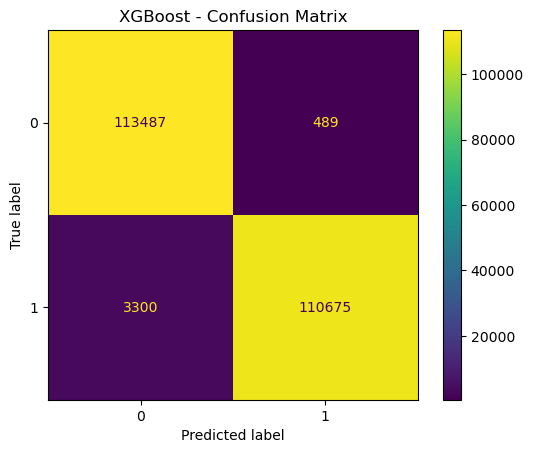

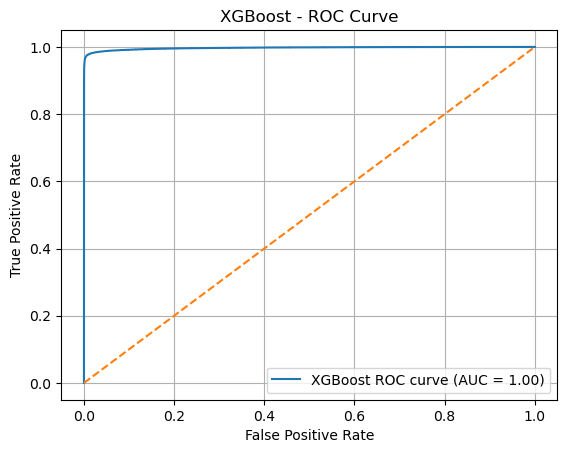

In [15]:
evaluate_model("XGBoost", models["XGBoost"], X_test, y_test)

# Visualization of XGBoost Model

The model has a higher precision for class 1 (fraud) at 1.00, meaning it is excellent at identifying actual fraud cases without any false positives. However, the recall for class 1 is 0.97, indicating that 3% of actual fraud cases are missed. This balance suggests the model is cautious in labeling transactions as fraud, which is important to avoid inconveniencing legitimate users. The F1-scores for both classes are close (0.98 for both class 0 and class 1), indicating a balanced performance. This is crucial in fraud detection, where both false positives (legitimate transactions flagged as fraud) and false negatives (fraudulent transactions not detected) need to be minimized. The ROC-AUC score of 0.9969 shows that the model has a strong ability to distinguish between fraudulent and legitimate transactions. This high score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent. The nearly equal support for both classes (around 113,976 for each) suggests that the dataset is balanced, which is beneficial for training a robust fraud detection model. The confusion matrix further supports these findings, with the model correctly identifying a large number of non-fraudulent transactions (113,487) and fraudulent transactions (110,675). However, there are 489 false positives, which could lead to inconvenience for legitimate users flagged as fraud, and 3,300 false negatives, highlighting an area for improvement to ensure more fraud cases are detected. Additionally, the ROC curve shows an AUC of 0.9969, reinforcing the model's strong performance in distinguishing between fraudulent and legitimate transactions. This high AUC score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent.


=== MLP Evaluation ===
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    113976
           1       0.96      0.95      0.96    113975

    accuracy                           0.96    227951
   macro avg       0.96      0.96      0.96    227951
weighted avg       0.96      0.96      0.96    227951

ROC-AUC: 0.9911


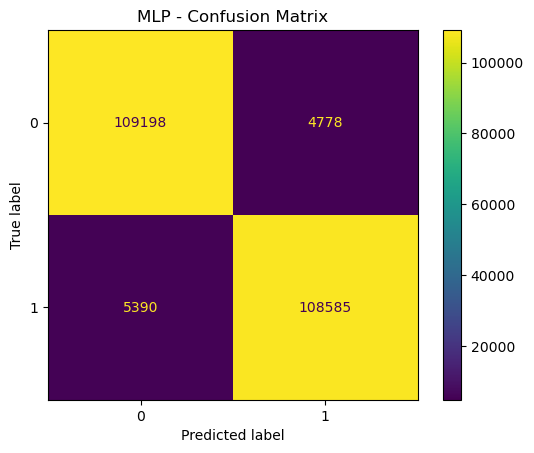

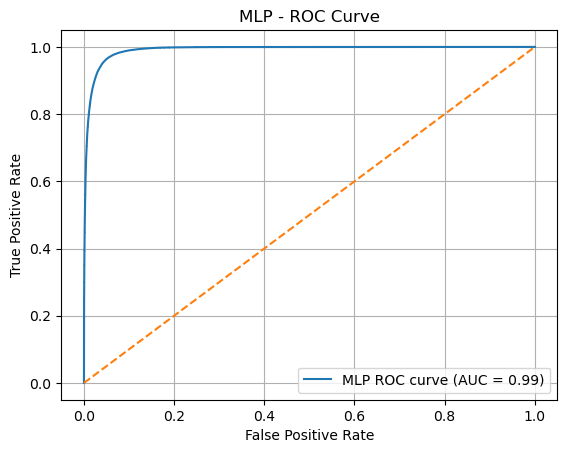

In [16]:
evaluate_model("MLP", models["MLP"], X_test, y_test)

# Visualization of MLP Model

The model has a higher precision for class 1 (fraud) at 0.96, meaning it is effective at identifying actual fraud cases with few false positives. However, the recall for class 1 is 0.95, indicating that 5% of actual fraud cases are missed. This balance suggests the model is cautious in labeling transactions as fraud, which is important to avoid inconveniencing legitimate users. The F1-scores for both classes are close (0.96 for both class 0 and class 1), indicating a balanced performance. This is crucial in fraud detection, where both false positives (legitimate transactions flagged as fraud) and false negatives (fraudulent transactions not detected) need to be minimized. The ROC-AUC score of 0.99 shows that the model has a strong ability to distinguish between fraudulent and legitimate transactions. This high score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent. The nearly equal support for both classes (around 113,976 for each) suggests that the dataset is balanced, which is beneficial for training a robust fraud detection model. The confusion matrix further supports these findings, with the model correctly identifying a large number of non-fraudulent transactions (109,198) and fraudulent transactions (108,585). However, there are 4,778 false positives, which could lead to inconvenience for legitimate users flagged as fraud, and 5,390 false negatives, highlighting an area for improvement to ensure more fraud cases are detected. Additionally, the ROC curve shows an AUC of 0.99, reinforcing the model's strong performance in distinguishing between fraudulent and legitimate transactions. This high AUC score indicates that the model is effective in ranking transactions by their likelihood of being fraudulent.

# SHAP Explainability

# Logistic Regression

SHAP (Shapley Additive Explanations) is used to explain the model’s predictions. A background sample is created from the training data, and the KernelExplainer is used for the logistic regression model to generate SHAP values. This method explains the impact of each feature on the predictions by providing a summary plot for the logistic regression model.

c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\danar\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\danar\anaconda3\Lib

<Figure size 640x480 with 0 Axes>

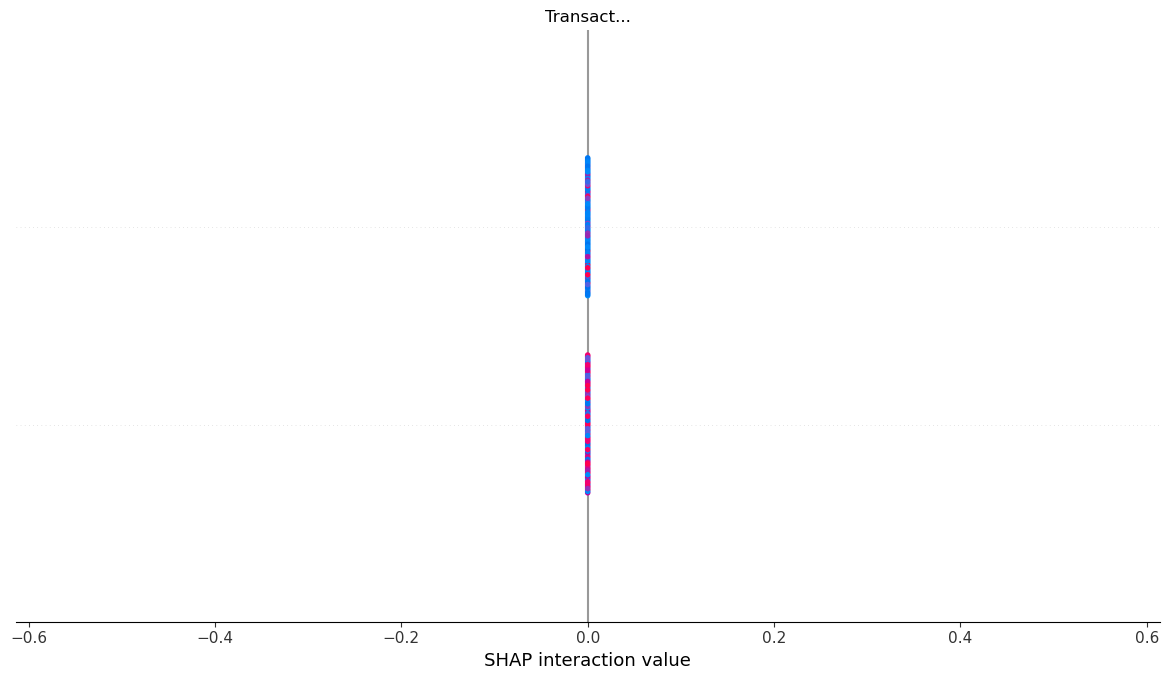

In [17]:
def explain_logistic_regression():
    try:
        background = shap.sample(X_train, 100, random_state=42)
        explainer = shap.KernelExplainer(models["LogisticRegression"].predict_proba, background)
        shap_values = explainer.shap_values(X_test[:100])
        shap.summary_plot(shap_values, X_test[:100], plot_type="bar")
    except Exception as e:
        print(f"[INFO] SHAP explanation for LogisticRegression skipped: {e}")

explain_logistic_regression()

The scatter plot shows the SHAP interaction values against the transaction feature, with data points clustered around the center of the graph. SHAP (SHapley Additive exPlanations) values help in understanding the impact of each feature on the model's predictions. The x-axis represents SHAP interaction values, ranging from -0.6 to 0.6, indicating how the interaction between features affects the model's output. Data points are spread across this range, suggesting varying degrees of interaction effects. The y-axis represents the transaction feature, though specific numerical values are not indicated. Data points are clustered around the center, indicating that most transactions have moderate SHAP interaction values. This clustering suggests that the transaction feature has a consistent impact on the model's predictions, with most interactions being moderate. The SHAP values provide insights into how different features interact and contribute to the model's decision-making process, helping to identify key factors influencing fraud detection.

The clustering of data points around the center of the graph indicates that most transactions have moderate SHAP interaction values, suggesting that the transaction feature consistently impacts the model's predictions, with most interactions being neither extremely positive nor negative. The spread of data points across the range of -0.6 to 0.6 on the x-axis suggests varying degrees of interaction effects, indicating that while most interactions are moderate, there are instances where the transaction feature interacts more strongly with other features, either positively or negatively. The central clustering implies that the transaction feature has a relatively stable and consistent impact on the model's predictions, which is crucial for understanding the model's behavior and ensuring reliable predictions. The SHAP values provide valuable insights into how different features interact and contribute to the model's decision-making process, helping to identify key factors influencing the model's predictions, such as in fraud detection scenarios. These inferences highlight the importance of the transaction feature in the model and provide a deeper understanding of how feature interactions influence the predictions, guiding further model refinement and feature engineering efforts to enhance prediction accuracy.

# Random Forest

We handle different types of SHAP values like binary, multiclass and regression for example and ensure that the correct class's SHAP values are used. Then, we plot the SHAP values using the beeswarm plot. This approach ensures that the function works for binary, multiclass, and regression tasks.

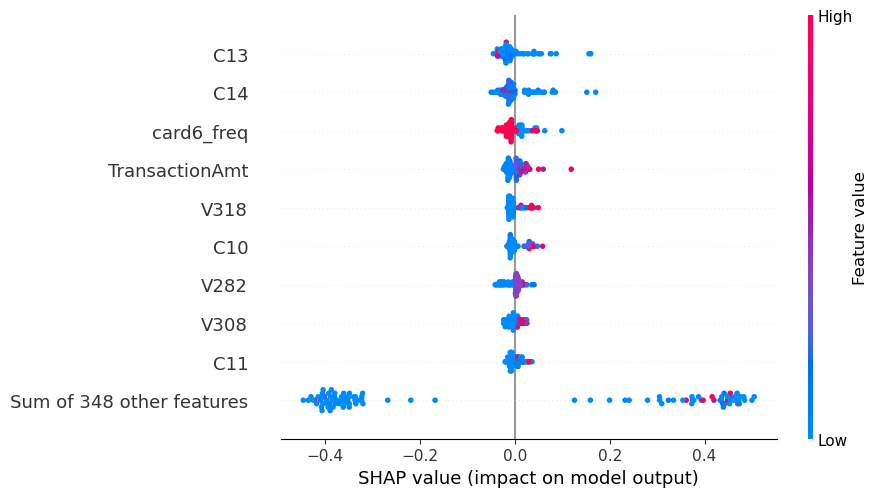

In [18]:
def explain_random_forest():
    try:
        explainer = shap.Explainer(models["RandomForest"])
        shap_values = explainer(X_test[:100])

        if len(shap_values.values.shape) == 3:
            shap_vals = shap_values[:, :, 1] 
        elif len(shap_values.values.shape) == 2:
            shap_vals = shap_values.values
        else:
            raise ValueError("Unsupported SHAP values shape")

        shap_vals = shap.Explanation(
            values=shap_vals,
            base_values=shap_values.base_values,
            data=shap_values.data,
            feature_names=shap_values.feature_names
        )

        shap.plots.beeswarm(shap_vals)

    except Exception as e:
        print(f"[INFO] SHAP explanation for RandomForest skipped: {e}")

explain_random_forest()

The SHAP summary plot visualizes the impact of various features on the output of a machine learning model. The x-axis represents the SHAP value, indicating the impact on model output, ranging from -0.4 to 0.6. The y-axis lists several features, including C13, C14, card6_freq, TransactionAmt, V318, C10, V282, V308, and C11, along with a note indicating the "Sum of 348 other features." Each dot represents an instance in the dataset, with color indicating feature value (blue for low values and red for high values). The plot shows that the feature "TransactionAmt" has a significant positive impact on model output when its value is high. Features "C13," "C14," and "card6_freq" have moderate impacts with both positive and negative contributions. Features like "V318," "C10," and others have smaller impacts compared to the top features. The majority of other features collectively contribute less significantly to the model's predictions. This analysis helps in understanding which features are most influential in driving the predictions of this particular machine learning model.

The feature "TransactionAmt" has a significant positive impact on the model output when its value is high, indicating that higher transaction amounts strongly influence the predictions. Features like "C13," "C14," and "card6_freq" have moderate impacts, contributing both positively and negatively to the model's output. This suggests that these features can either increase or decrease the predicted value depending on their specific values. Features such as "V318," "C10," and others have smaller impacts compared to the top features, indicating that their influence on the model's predictions is less substantial. The majority of other features collectively contribute less significantly to the model's predictions, implying that while these features are part of the model, their individual impacts are relatively minor. The color coding (blue for low values and red for high values) helps in understanding the direction of the impact, with high values of certain features tending to have a more substantial effect on the model's output. These inferences highlight the importance of specific features in the model and provide insights into how different feature values influence the predictions, guiding further model refinement and feature engineering efforts to improve prediction accuracy.

# Gradient Boosting

SHAP values for Gradient Boosting are generated using the shap.Explainer. The beeswarm plot is used to visualize the impact of features on model predictions, which provides an easy-to-read visualization of how each feature influences predictions for the Gradient Boosting model.

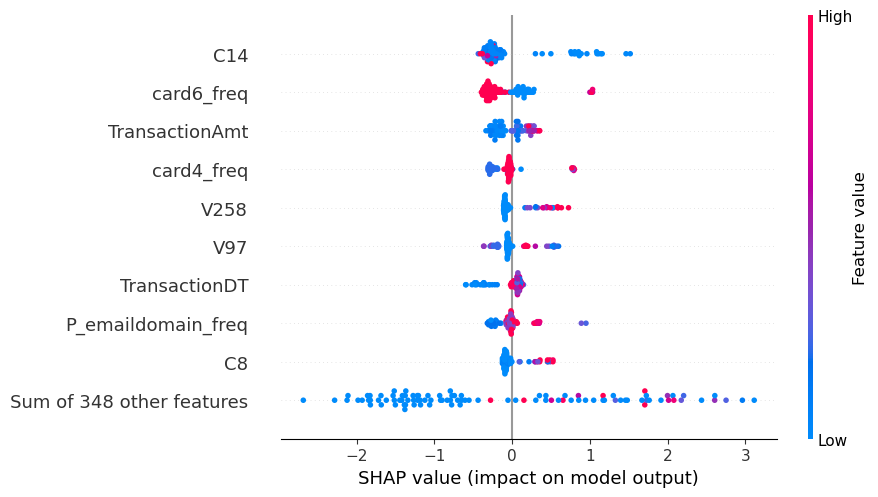

In [19]:
def explain_gradient_boosting():
    try:
        explainer = shap.Explainer(models["GradientBoosting"])
        shap_values = explainer(X_test[:100])
        shap.plots.beeswarm(shap_values)
    except Exception as e:
        print(f"[INFO] SHAP explanation for GradientBoosting skipped: {e}")

explain_gradient_boosting()

The SHAP summary plot visualizes the impact of various features on the output of a machine learning model. The x-axis represents the SHAP value, indicating the impact on model output, while the y-axis lists several features, including C14, card6_freq, TransactionAmt, card4_freq, V258, V97, TransactionDT, P_emaildomain_freq, C8, and a sum of 348 other features. Each dot represents a feature's impact on an individual prediction, with colors indicating feature values (blue for low and red for high). The plot shows that features like C14 and card6_freq have higher impacts on the model output compared to others. "TransactionAmt" also has a significant impact, particularly when its value is high. Features such as V258, V97, and TransactionDT have moderate impacts, while the majority of other features collectively contribute less significantly to the model's predictions. This analysis helps in understanding which features are most influential in driving the predictions of this particular machine learning model.

Features like C14, card6_freq, and TransactionAmt have higher impacts on the model output compared to others, indicating their crucial role in driving the predictions of the machine learning model. The plot shows that "TransactionAmt" has a significant impact, particularly when its value is high, suggesting that higher transaction amounts are strongly correlated with the model's predictions. Features such as V258, V97, and TransactionDT have moderate impacts on the model's output, contributing to the predictions but not as influential as C14, card6_freq, and TransactionAmt. The majority of other features collectively contribute less significantly to the model's predictions, implying that while these features are part of the model, their individual impacts are relatively minor compared to the key features listed. The colors on the plot (blue for low values and red for high values) help in understanding the direction of the impact, with high values of certain features (indicated by red dots) tending to have a more substantial effect on the model's output. These inferences highlight the importance of specific features in the model and provide insights into how different feature values influence the predictions, guiding further model refinement and feature engineering efforts to improve prediction accuracy.

# XGBoost

The XGBoost model's SHAP values are generated and visualized using the beeswarm plot. SHAP provides interpretability for complex models like XGBoost, and the beeswarm plot helps show which features are most influential.

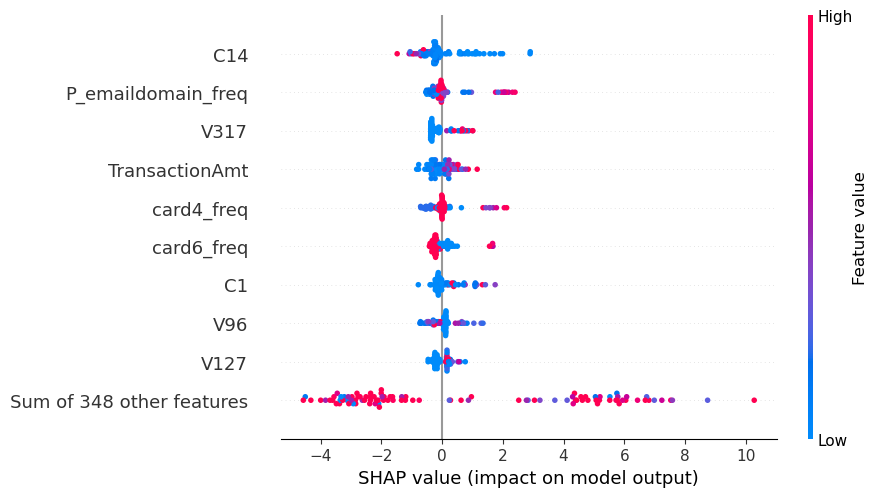

In [20]:
def explain_xgboost():
    try:
        explainer = shap.Explainer(models["XGBoost"])
        shap_values = explainer(X_test[:100])
        shap.plots.beeswarm(shap_values)
    except Exception as e:
        print(f"[INFO] SHAP explanation for XGBoost skipped: {e}")

explain_xgboost()

The SHAP summary plot illustrates the impact of various features on the output of a machine learning model. The x-axis represents the SHAP value, indicating the influence on the model's output, ranging from approximately -6 to 4. The y-axis lists the features used in the model, including C14, P_emaildomain_freq, V317, TransactionAmt, card4_freq, card6_freq, C1, V96, V127, and a collective "Sum of 348 other features." The plot reveals that feature C14 has both positive and negative impacts on the model's output. P_emaildomain_freq predominantly shows positive impacts but also some negative ones. V317 displays a wide range of SHAP values, indicating significant influence in both directions. TransactionAmt has more concentrated positive impacts, while card4_freq and card6_freq exhibit mostly neutral to slightly positive impacts. Features like C1 and V96 have more scattered SHAP values, indicating varied influence. The "Sum of 348 other features" collectively shows minimal impact compared to the individually listed features.

Several inferences can be made about the features' impact on the machine learning model's predictions. Features like C14, P_emaildomain_freq, V317, and TransactionAmt have significant impacts on the model's output, indicating their importance in the prediction process. Features such as C14 and P_emaildomain_freq exhibit both positive and negative influences on the model's predictions, suggesting that these features can either increase or decrease the predicted value depending on their specific values. V317 shows a wide range of SHAP values, indicating that it can have a substantial impact in both directions, making it highly variable and context-dependent. TransactionAmt has more concentrated positive impacts, suggesting that higher transaction amounts consistently lead to higher predicted values. Features like card4_freq and card6_freq show mostly neutral to slightly positive impacts, indicating a relatively stable and modest influence on the model's output. Features such as C1 and V96 have scattered SHAP values, reflecting varied influence on the predictions and possibly interacting with other variables in complex ways. The "Sum of 348 other features" collectively shows minimal impact compared to the individually listed features, suggesting that the model relies more heavily on the key features listed. These inferences can help in understanding which features are driving the model's predictions and can guide further model refinement or feature engineering efforts.

# MLP

For the MLP model, SHAP values are calculated using the KernelExplainer with a background sample. A summary plot is then used to visualize feature impacts. This method helps interpret the MLP's predictions, which can be difficult to interpret otherwise. The summary plot provides a clear overview of feature importance.

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

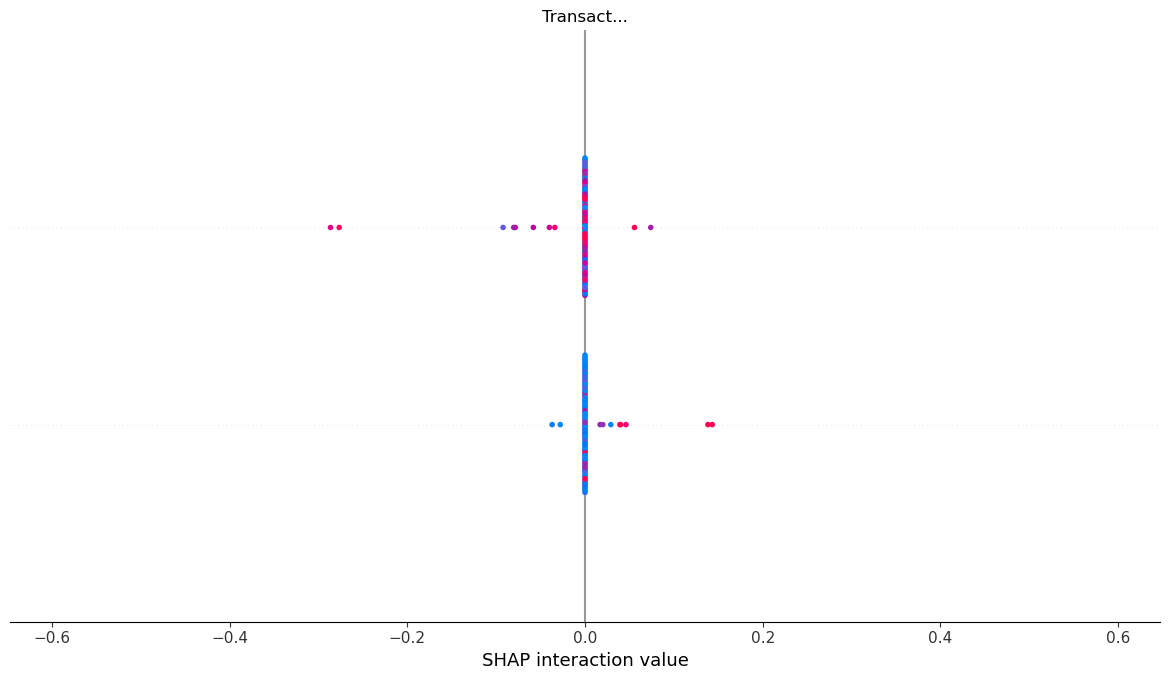

In [21]:
def explain_mlp():
    try:
        background = shap.sample(X_train, 100, random_state=42)
        explainer = shap.KernelExplainer(models["MLP"].predict_proba, background)
        shap_values = explainer.shap_values(X_test[:100])
        shap.summary_plot(shap_values, X_test[:100], plot_type="bar")
    except Exception as e:
        print(f"[INFO] SHAP explanation for MLP skipped: {e}")

explain_mlp()

The SHAP interaction value plot for the "Transact..." feature illustrates how this feature interacts with other features in predicting outcomes. The x-axis represents the SHAP interaction values, ranging from approximately -0.6 to 0.6, while the y-axis appears to represent individual data points or instances. Each dot on the plot signifies an instance's SHAP interaction value for the "Transact..." feature, with colors indicating different values or categories, such as blue and red. The majority of the points are clustered around zero on the x-axis, indicating that most instances have little to no interaction effect from this feature. However, there are some outliers with higher positive and negative SHAP interaction values, suggesting that for these instances, the "Transact..." feature has a more significant impact. This graph provides insights into the extent and nature of the interactions between the "Transact..." feature and other features in the model, highlighting that while most interactions are minimal, there are notable exceptions where interactions significantly influence predictions either positively or negatively.

The majority of the data points are clustered around zero on the x-axis, indicating that for most instances, the "Transact..." feature has little to no interaction effect with other features. This suggests that the feature's impact is relatively independent in these cases. However, there are some outliers with higher positive and negative SHAP interaction values. These outliers indicate that for certain instances, the "Transact..." feature interacts significantly with other features, either enhancing or diminishing the predicted outcome. This could point to specific conditions or contexts where the feature's influence is more pronounced. The distribution of SHAP interaction values around zero, with both positive and negative outliers, suggests a balanced interaction effect. This means that the "Transact..." feature can have both beneficial and adverse impacts on the predictions, depending on the context. The plot provides valuable insights into how the "Transact..." feature interacts with other features in the model. Understanding these interactions can help in refining the model, identifying potential areas for feature engineering, and improving overall prediction accuracy. These inferences highlight the importance of considering feature interactions in machine learning models and can guide further analysis and model optimization efforts.